# Special Model Comparison

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

%load_ext autoreload
%autoreload 2

In [2]:
from util import databases
from util import dataloader
from util import grid_models
from util.reddit_functions import Labeler, TextClassifier
from util.reddit_functions import plot_confusion_matrix
from util.grid_models import custom_stop_words

In [3]:
# subreddit_list = ['css', 'html', 'javascript', 'php', 'perl', 'java', 'datascience', 'machinelearning', 'etl', 'python', 'dataengineering']

In [4]:
subreddit_list = ['datascience','machinelearning','dataengineering','python','aws']

In [5]:
df = dataloader.data_selector(subreddit_list, 'sqlite')

Connection to SQLite DB successful


In [6]:
df.sample(10)

,title,subreddit,date
49771,[P] Made this simple GUI tool to organize and ...,machinelearning,2020-04-27
8838,Kicking the tires on BigQuery – Google’s Serve...,dataengineering,2020-04-02
185,Are all t2 EC2's free?,aws,2020-03-29
68712,[D] Any general tips to debug your Seq2Seq mod...,machinelearning,2020-05-02
3910,Dumb question: when do you know to use rank an...,dataengineering,2020-03-29
52086,Analysis of which data engineer tech skills ar...,dataengineering,2020-04-27
22721,[HELP] Unsure how to fix UnicodeDecodeError wh...,python,2020-04-20
24513,AWS service names - AWS vs Amazon. How do they...,aws,2020-04-21
23579,Has anyone user Redis streams for realtime dat...,dataengineering,2020-04-20
8043,Cursor has no attribute cursor ERROR,python,2020-04-02


In [7]:
X = df['title']
y = df['subreddit']

In [8]:
labeler = Labeler()
labeler.fit(y)
y = labeler.transform(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [10]:
tfidfvectorizer = {
    'preprocessor': TfidfVectorizer(stop_words=custom_stop_words),
    'pipe_params': {
        "tfidfvectorizer__ngram_range": [(1, 2)],
#         "prep__max_df": [.7, .8, .9],
        "tfidfvectorizer__use_idf": [True],
        "tfidfvectorizer__norm": ["l2"]
    }
}

In [17]:
estimators = {
    'logisticregression': {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(max_iter=1000),
        'pipe_params': {
            "logisticregression__C": [5]
        }
    },
    'mlp': {
        'name': 'Multi Layer Percetpron Classifier',
        'estimator': MLPClassifier(),
        'pipe_params': {
            "clf__hidden_layer_sizes": [50, 100, 200]
        }
    },

    'xgbclassifier': {
        'name': 'XGBoost Classifier',
        'estimator': XGBClassifier(),
        'pipe_params': {
            "clf__hidden_layer_sizes": [10, 25, 50],
            "clf__n_estimators": [50, 100, 200],
            "clf__max_depth": [5, 10, 20]
        }
    }
}

In [18]:
def score_model(model):
    
    print(f'Train Score: {model.score(X_train, y_train)}')
    print(f'Test Score: {model.score(X_test, y_test)}')
    print(f'AUC Score: {roc_auc_score(y_test, y_proba, multi_class="ovr")}')
    print(classification_report(y_test, y_pred, digits=3))

In [19]:
fitted_models = dict()

In [20]:
text = TextClassifier()

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.6s finished


Train Score: 0.9927604236492827
Test Score: 0.9852697199738575
AUC Score: 0.9985345183225853
              precision    recall  f1-score   support

           0      0.992     0.993     0.993      3967
           1      0.983     0.978     0.981      3712
           2      0.988     0.991     0.990      4259
           3      0.982     0.976     0.979      3825
           4      0.980     0.986     0.983      4128

    accuracy                          0.985     19891
   macro avg      0.985     0.985     0.985     19891
weighted avg      0.985     0.985     0.985     19891

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:    3.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:    4.8s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapsed:    5.7s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    6.0s finished


Train Score: 0.33927135004692316
Test Score: 0.3375898647629581
AUC Score: 0.6076563974854567
              precision    recall  f1-score   support

           0      0.845     0.294     0.437      3967
           1      0.000     0.000     0.000      3712
           2      0.251     0.981     0.399      4259
           3      0.745     0.358     0.484      3825
           4      0.000     0.000     0.000      4128

    accuracy                          0.338     19891
   macro avg      0.368     0.327     0.264     19891
weighted avg      0.365     0.338     0.266     19891



/Users/chris/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


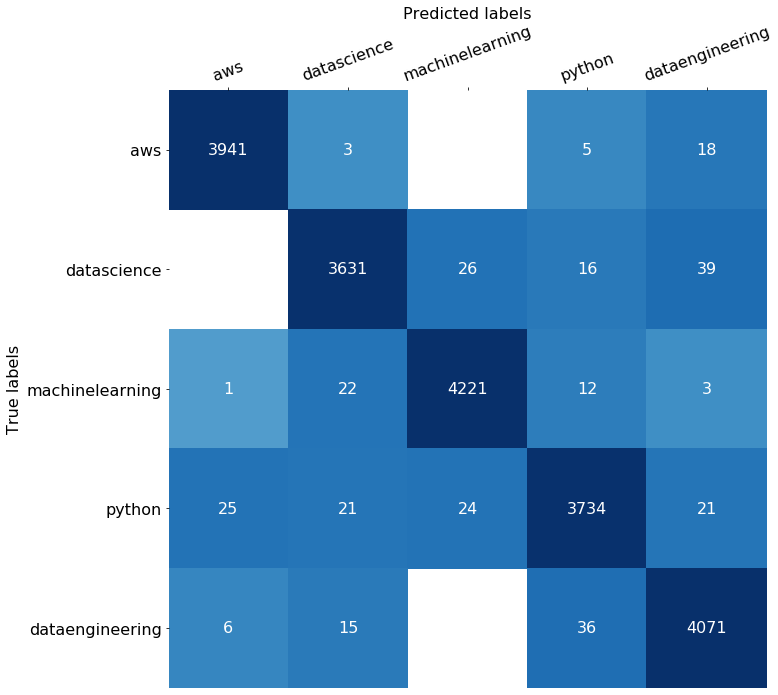

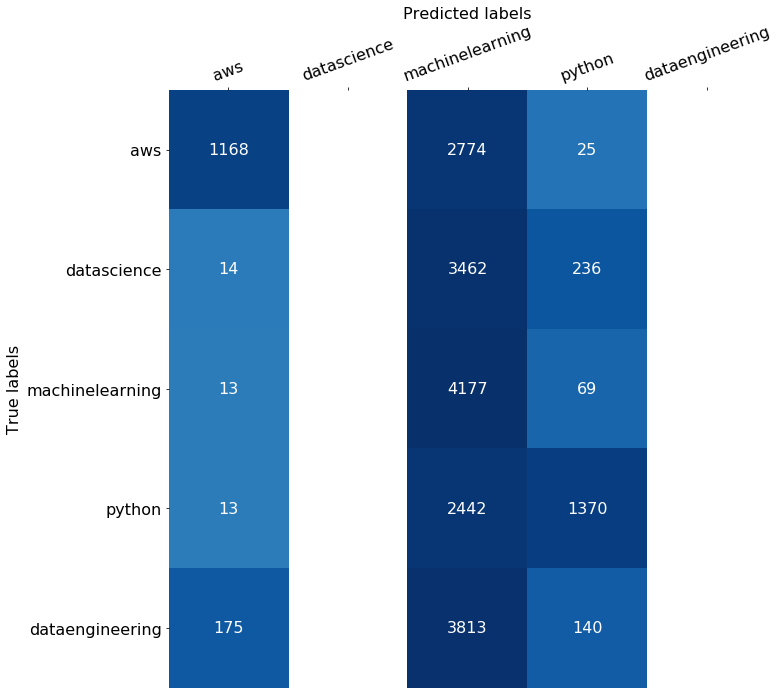

In [21]:
for estimator in estimators.values():

    model = text.build_and_train_model(
        text=X_train,
        labels=y_train,
        preprocessor=tfidfvectorizer,
        estimator=estimator,
        verbose=5
    )
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    score_model(model)
    plot_confusion_matrix(model, y_true=y_test,
                          y_pred=y_pred, classes=labeler.classes_)
    fitted_models[estimator.get('name')] = model

In [ ]:
fitted_models